# Tuto_003 : Predictor/Corrector 

The purpose of this tutorial is to introduce the concept of continuation procedure. The continuation procedure consists in a prediction/correction procedure that would increase drastically the chances of the nonlinear solver to be able to converge. It also allows the code to pass through complex points such as bifurcations. 

The tutorial is based on the pendulum equations that have been used in the last tutorial and is following the agenda given below : 
1. Why use a predictor ? 
2. Some flexibility thanks to the correctors
3. Turning points and the importance of bifurcations


In [1]:
## This block makes the mandatory imports and configure matplotlib for figures
## Some help function is also define here (get_frf)
import sys
# ------------------ IMPORTS ------------------ #
import copy
import numpy as np
import os
import matplotlib.pyplot as plt
import pyHarm
import json
import scipy.io
from pyHarm.Elements.FactoryElements import ElementDictionary
from pyHarm.Elements.ABCElement import ABCElement

# ------------------ MATPLOTLIB DEFAULT STYLE ------------------ #
plt.style.use('default')
FONT_BASE = 25
width_fig = 15
ratio_fig = (width_fig,1/(16/10.)*width_fig)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
plt.rc('xtick', labelsize=FONT_BASE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_BASE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_BASE)    # legend fontsize
plt.rc('axes', labelsize=FONT_BASE)
plt.rc('axes', titlesize=FONT_BASE+5) #fontsize of the title

style_plots_ref = {"frf_lin":{"linestyle":"dashed","color":np.array([0,0,0]),\
                          "label":"Linear solution"},\
                   "frf_lin_nothing":{"linestyle":"dashed","color":np.array([0,.25,1.]),\
                          "label":"Linear solution no prediction nor correction","linewidth":2,\
                                     "marker":"o"},\
                   "frf_lin_pred":{"linestyle":"dashed","color":np.array([1,.25,0]),\
                          "label":"Linear solution with prediction","linewidth":2,\
                                     "marker":"s"},\
                   "frf_lin_predcor":{"linestyle":"dashed","color":np.array([.2,1.,.2])*.7,\
                          "label":"Linear solution with prediction and correction","linewidth":2,\
                                     "marker":"d"},\
                   "frf_nl_cubic":{"linestyle":"solid","linewidth":2,"color":np.array([255,140,0])/255.,\
                           "marker":".",\
                         "label":"nonlinear solution with cubic connector"},\
                   "frf_nl_cubicB":{"linestyle":"solid","linewidth":2,"color":np.array([0,140,255])/255.,\
                           "marker":".",\
                         "label":"nonlinear solution with cubic connector backward"},\
                   "frf_nl_bifurc":{"linestyle":"solid","linewidth":2,"color":np.array([255/8.,255,255/8.])/255.,\
                           "marker":".",\
                         "label":"nonlinear solution with bifurcation detection"},\
                   "frf_nl_sin":{"linestyle":"solid","linewidth":2,"color":np.array([0,140,255])/255.,\
                           "marker":".",\
                         "label":"nonlinear solution with true sinus connector"},
                  }
SAVE = False

# ------------------ function for FRF ------------------ #
def get_frf(M,indices_selection=('sub1', 0, 0),analysis="FRF"): 
    indexH = M.getIndex(*indices_selection)
    SA = [sol for sol in M.nls[analysis].SolList if sol.flag_accepted]
    om = np.array([sol.x[-1] for sol in SA])
    ampH = np.array([np.linalg.norm(sol.x[indexH]) for sol in SA])
    return SA,om,ampH

## Why use a predictor ? 

Because nonlinear solvers are not globally convergent but only locally, it is important to give as a starting point a good initial guess. In pyHarm, there exists some of the most classical predictors in order to give a good initial guess to the nonlinear solver. In this part of the tutorial we propose to the users to code a predictor that would give the null vector as a predictor at each step. 

### Construction of a new stopping criterion

Because the code will fail to converge properly in this exercises, a new stopping criterion is first constructed. This stopping criterion analyses the number of solution points that have not reached convergence (meaning the nonlinear solver has not been able to solve the problem correctly) and stops the analysis if too many failures have been obtained.
- Complete the `failnumber_reached` function in order to stop the analysis whenever the solver has failed too many times to converge 


In [2]:
from pyHarm.Solver import SystemSolution,FirstSolution
from pyHarm.StopCriterion.FactoryStopCriterion import Stopper_dico,StopCriterionBounds
from Tuto_003_predictorcorrector_correctionfunctions import failnumber_reached_corr
from pyHarm.BaseUtilFuncs import pyHarm_plugin

### USER MODIFICATIONS ATTENDED ###
def failnumber_reached(sollist:list[SystemSolution], failnumber_threshold:int, stop:bool) -> bool:
    """sollist contains all the solution points that have been seen during the analysis 
    including the false convergence. A solution inside the sollist has been rejected if 
    the flag solution.flag_accepted is set to False.
    Provides a function that returns True if the number of fail is higher that the threshold"""
    return True # to be modified  
### END USER MODIFICATION ###

class StopCriterionFailNumber(StopCriterionBounds):
    factory_keyword = "fail"
    fail_accepted = 10 # you can play with this value
    def getStopCriterionStatus(self,sol:SystemSolution,sollist:list[SystemSolution],**kwargs) -> bool:
        stop = super().getStopCriterionStatus(sol,sollist,**kwargs)
        stop = failnumber_reached_corr(sollist,self.fail_accepted,stop) # here is your coded function
        return stop

pyHarm_plugin(StopCriterionFailNumber)


### Construction of a null predictor 

In order to better apprehend the importance of the predictors, we propose here to code the worst kind of predictor and use it in the pendulum problem to see its effect. The worst predictor would be to initialize the starting point to be the null vector. 
- Complete the `compute_direction` function in order to obtain the direction of the guess of the next point
- Complete the `xpred_null_guess` function in order to obtain the null vector as a starting point for the next step of the analysis

In [3]:
from pyHarm.Predictors.FactoryPredictor import ABCPredictor,Predictor_dico
from Tuto_003_predictorcorrector_correctionfunctions import compute_direction_corr,xpred_null_guess_corr
    

### USER MODIFICATIONS ATTENDED ###
def compute_direction(x_size:int) -> np.ndarray:
    """Computes the direction of the guess for the next point.
    The angular frequency is the last element in the vector ([-1])."""
    pass # to be modified  
def xpred_null_guess(lstp_x:np.ndarray,direction:np.ndarray,ds:float, sign_ds:int) -> np.ndarray:
    """Computes the x predicted using the direction of prediction, 
    the step size and its sign, and the vector of the last accepted point.
    Remember to use the angular frequency of the last solution point lstp_x[-1]"""
    pass # to be modified  
### END USER MODIFICATION ###


class PredictorNullSolution(ABCPredictor):
    """Defines the null solution type of predictor."""
    predictor_name = "Null Solution Predictor"
    factory_keyword = "null"
    def predict(self, sollist:list[SystemSolution], ds:float, k_imposed=None) -> tuple[np.ndarray,SystemSolution,float]:
        lstpt = self.getPointerToSolution(sollist,k_imposed) # get associated last accepted point
        lstpt.getJacobian("full") # get the Jacobian of the previous accepted point
        self.bifurcation_detect(lstpt) # Detect if bifurcation is present
        
        lstp_x = lstpt.x # last accepted point solution vector
        ### CHANGE FUNCTIONS BELOW TO YOUR OWN
        direction = compute_direction_corr(lstp_x.size) # get the direction of prediction
        xpred = xpred_null_guess_corr(lstp_x, direction, ds, self.sign_ds)
        
        lstpt.dir = direction
        lstpt.x_pred = xpred
        return xpred,lstpt,self.sign_ds
pyHarm_plugin(PredictorNullSolution)



In [4]:
# ------------------ SYSTEM CONSTRUCTION ------------------ #
m = 30.
g = 9.81
R = 1. * 2
C = 1e-1
FE = 1.2e1 + 4.

MassMatrix = np.array([[1.]])
DampMatrix = C * np.array([[1.]])
RigidMatrix = np.array([[g/R]])
LinSys = dict()
LinSys["M"] = MassMatrix
LinSys["C"] = DampMatrix
LinSys["K"] = 0 * RigidMatrix
LinSys["G"] = 0 * MassMatrix


# ------------------ INPUT CONSTRUCTION ------------------ #
INP = \
{
    "analysis": {"FRF":{
                "study":"frf",
                "puls_inf":0.1,
                "puls_sup":7.0,
                "ds_min": 1e-12,
                "ds0": 3e-3,
                "ds_max": 3e-3,
                "sign_ds": 1,
                "verbose":True,
                "solver":"scipyroot",
                "predictor":"null",
                "corrector":"nocontinuation",
                "stopper":"fail",
                "stepsizer":"constant",
                "predictor_options": {"verbose":True}
             }},
    "system":{"type":"Base",
              "nh":5,
              "nti":128,
            "adim": {"status": False,
                    "lc": 1.0,
                    "wc": 1.0}},

    "substructures": {
                "sub1": {
                    "matrix": LinSys,
                    "ndofs" : 1
                }
            },
    "connectors": {
        "loading": {
            "type":"CosinusForcing",
            "connect" : {"sub1":[0]},
            "dirs":[0],
            "amp" : FE / (m*R)
        },
        },


}



INP_lin = copy.deepcopy(INP) # new input from the template
# A new connector is added
INP_lin["connectors"]["linGravity"] = {"type":"LinearSpring",
                                       "connect" : {"sub1":[0]},
                                       "dirs":[0],
                                       "k" : g/R
        }

In [5]:
Lin_nothing = pyHarm.Maestro(INP_lin) # Creation of the Maestro
Lin_nothing.operate("null") # Run the analysis with the "null" guess as starting point

solution converged at om=0.1
solution converged at om=0.10300000000000001
solution converged at om=0.10600000000000001
solution converged at om=0.10900000000000001
solution converged at om=0.11200000000000002
solution converged at om=0.11500000000000002
solution converged at om=0.11800000000000002
solution converged at om=0.12100000000000002
solution converged at om=0.12400000000000003
solution converged at om=0.12700000000000003
solution converged at om=0.13000000000000003
solution converged at om=0.13300000000000003
solution not accepted at om=0.13600000000000004
solution not accepted at om=0.13600000000000004
solution not accepted at om=0.13600000000000004
solution not accepted at om=0.13600000000000004
solution not accepted at om=0.13600000000000004
solution not accepted at om=0.13600000000000004
solution not accepted at om=0.13600000000000004
solution not accepted at om=0.13600000000000004
solution not accepted at om=0.13600000000000004
solution not accepted at om=0.13600000000000

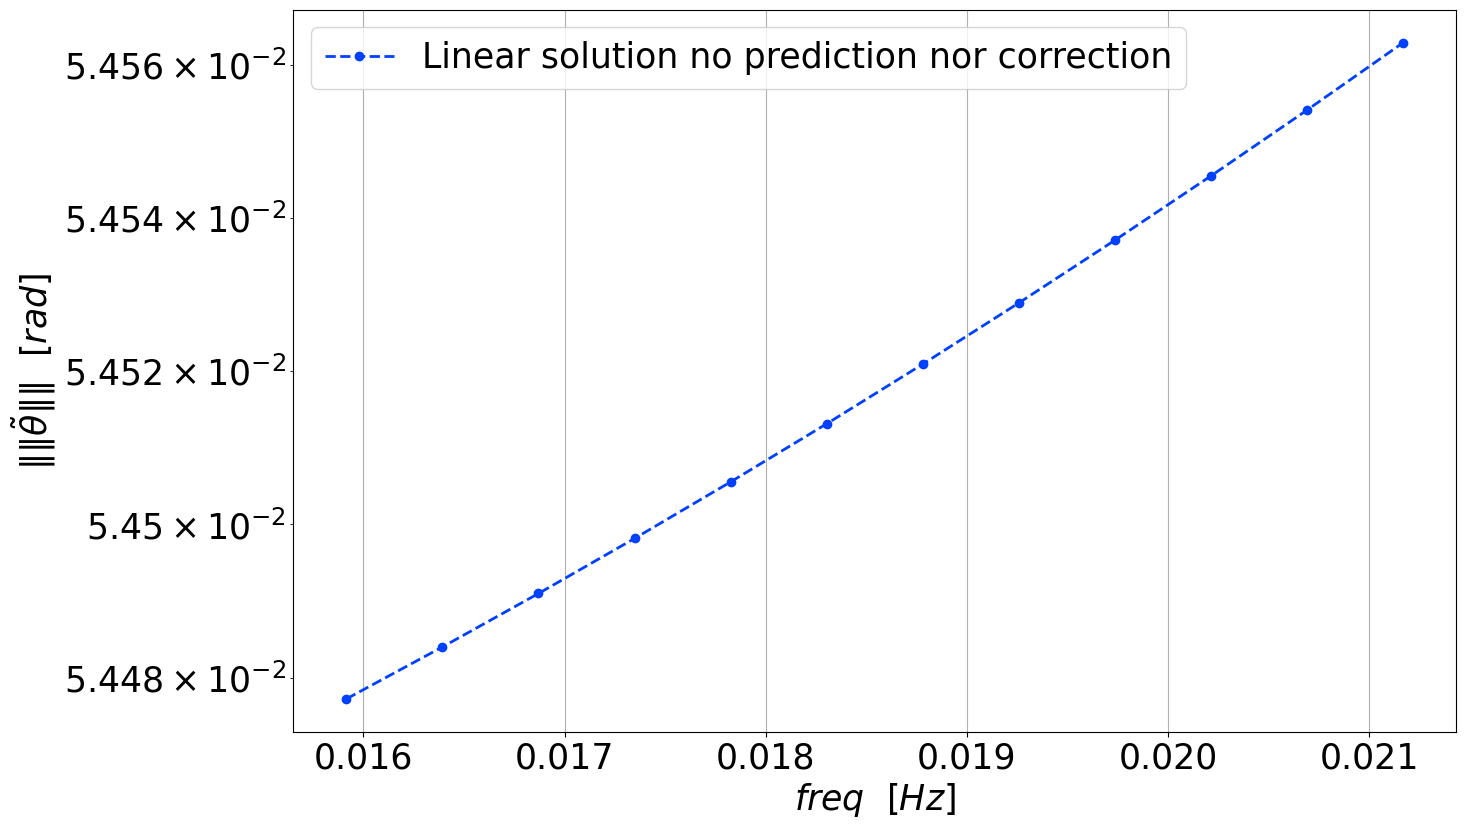

In [6]:
# -------------------- Draw of the frf -------------------- #
SA_lin_nothing, om_lin_nothing, ampH_lin_nothing = get_frf(Lin_nothing) # from the Maestro object, we extract some FRF by run the 
# get_frf function defined at the top of the notebook

fig,ax = plt.subplots(figsize=ratio_fig)
ax.plot(om_lin_nothing/(2*np.pi),ampH_lin_nothing,**style_plots_ref["frf_lin_nothing"])
ax.set_xlabel("$freq~~[Hz]$")
ax.set_ylabel("$\|\| \\tilde{\\theta} \|\|~~[rad]$")
ax.legend()
ax.grid()
ax.set_yscale("log")


The code is unable to converge due to the predictor that is giving a really bad guess as a starting point for the next step to be calculated. There exists numerous predictors that can be used, but two are the most popular : 
- **tangent predictor** : predict a point using the Jacobian information at the previous solution point. A tangent of the R(x)=0 is drawn and used as a direction to make a prediction for the next point
- **secant predictor** : this predictor uses the secant between the last two converged points to draw a direction from which the next guess is made. This predictor requires lower order information and is thus less precise, but can become more robust in badly conditioned areas

Some other predictor can be drawn from the same type of ideas by using second order information from the Hessian, or making a mix between tangent and secant. Last, a predictor that is less efficient but really easy consists in taking the previous solution as a guess

In the next block, the predictor is changed and the calculation is ran again. The student can try the other available predictors : 
- `previous`
- `secant`
- `tangent`


In [7]:
# -------------------- Linear problem -------------------- #
INP_pred = copy.deepcopy(INP_lin) 
INP_pred["analysis"]["FRF"]["predictor"] = "secant" # you can play here with the different predictors
Pred = pyHarm.Maestro(INP_pred) 
Pred.operate("null") 

solution converged at om=0.1
solution converged at om=0.10299999071071471
solution converged at om=0.10599998119445098
solution converged at om=0.10899997121378018
solution converged at om=0.11199996075468863
solution converged at om=0.11499994980312017
solution converged at om=0.11799993834497495
solution converged at om=0.12099992636610805
solution converged at om=0.12399991385232827
solution converged at om=0.1269999007893968
solution converged at om=0.12999988716302596
solution converged at om=0.13299987295887786
solution converged at om=0.13599985816256305
solution converged at om=0.1389998427596393
solution converged at om=0.14199982673561024
solution converged at om=0.14499981007592394
solution converged at om=0.14799979276597167
solution converged at om=0.1509997747910865
solution converged at om=0.15399975613654196
solution converged at om=0.15699973678755066
solution converged at om=0.15999971672926294
solution converged at om=0.16299969594676544
solution converged at om=0.16

In [8]:
# -------------------- Draw of the frf -------------------- #
SA_pred, om_pred, ampH_pred = get_frf(Pred) 

fig,ax = plt.subplots(figsize=ratio_fig)
ax.plot(om_pred/(2*np.pi),ampH_pred,**style_plots_ref["frf_lin_pred"])
ax.plot(om_lin_nothing/(2*np.pi),ampH_lin_nothing,**style_plots_ref["frf_lin_nothing"])
ax.set_xlabel("$freq~~[Hz]$")
ax.set_ylabel("$\|\| \\tilde{\\theta} \|\|~~[rad]$")
ax.legend()
ax.grid()
ax.set_yscale("log")


Even if the code shall have terminated further, the code has not been able to converge on the whole angular frequency range for certain predictors. This is partly due to the fact that solving the problem for a fixed angular frequency $\omega$ is quite challenging. 

## Some flexibility thanks to the correctors

The code is using what is called a continuation procedure. This procedure consists in adding the angular frequency $\omega$ as a variable in the HBM problem. Adding a new variable into the HBM system means that we miss one equation to complete the system. This missing equation is called the **correction equation**. There exists two main correction equation used, the most popular being called the `arc_length` correction. It gives the liberty of the solver to look for a solution in a larger space by having the capacity to modify the angular frequency value inside an hypersphere of radius equal to the distance between the last converged point and the new starting point. This flexibility is a god sent for the nonlinear solver and reduce drastically the failure chances.

An other popular correction equation is the `pseudo_arc_length` that consists in allowing the solver to look for a solution perpendicular to the prediction direction.

In the next block, the same test case is ran using the `arc_length` corrector.

In [9]:
# -------------------- Linear problem -------------------- #
INP_predcor = copy.deepcopy(INP_lin) # new input from the template
INP_predcor["analysis"]["FRF"]["predictor"] = "secant"
INP_predcor["analysis"]["FRF"]["corrector"] = "arc_length"
PredCor = pyHarm.Maestro(INP_predcor) # Creation of the Maestro
PredCor.operate("null") # Run the analysis with the "null" guess as starting point

solution converged at om=0.1
solution converged at om=0.10299999048373629
solution converged at om=0.10599998050306556
solution converged at om=0.10899997004397415
solution converged at om=0.11199995909240593
solution converged at om=0.11499994763426102
solution converged at om=0.11799993565539454
solution converged at om=0.1209999231416153
solution converged at om=0.12399991007868448
solution converged at om=0.1269998964523144
solution converged at om=0.12999988224816722
solution converged at om=0.13299986745185347
solution converged at om=0.13599985204893092
solution converged at om=0.1389998360249032
solution converged at om=0.14199981936521844
solution converged at om=0.14499980205526786
solution converged at om=0.14799978408038456
solution converged at om=0.1509997654258421
solution converged at om=0.15399974607685307
solution converged at om=0.15699972601856785
solution converged at om=0.15999970523607307
solution converged at om=0.16299968371439033
solution converged at om=0.165

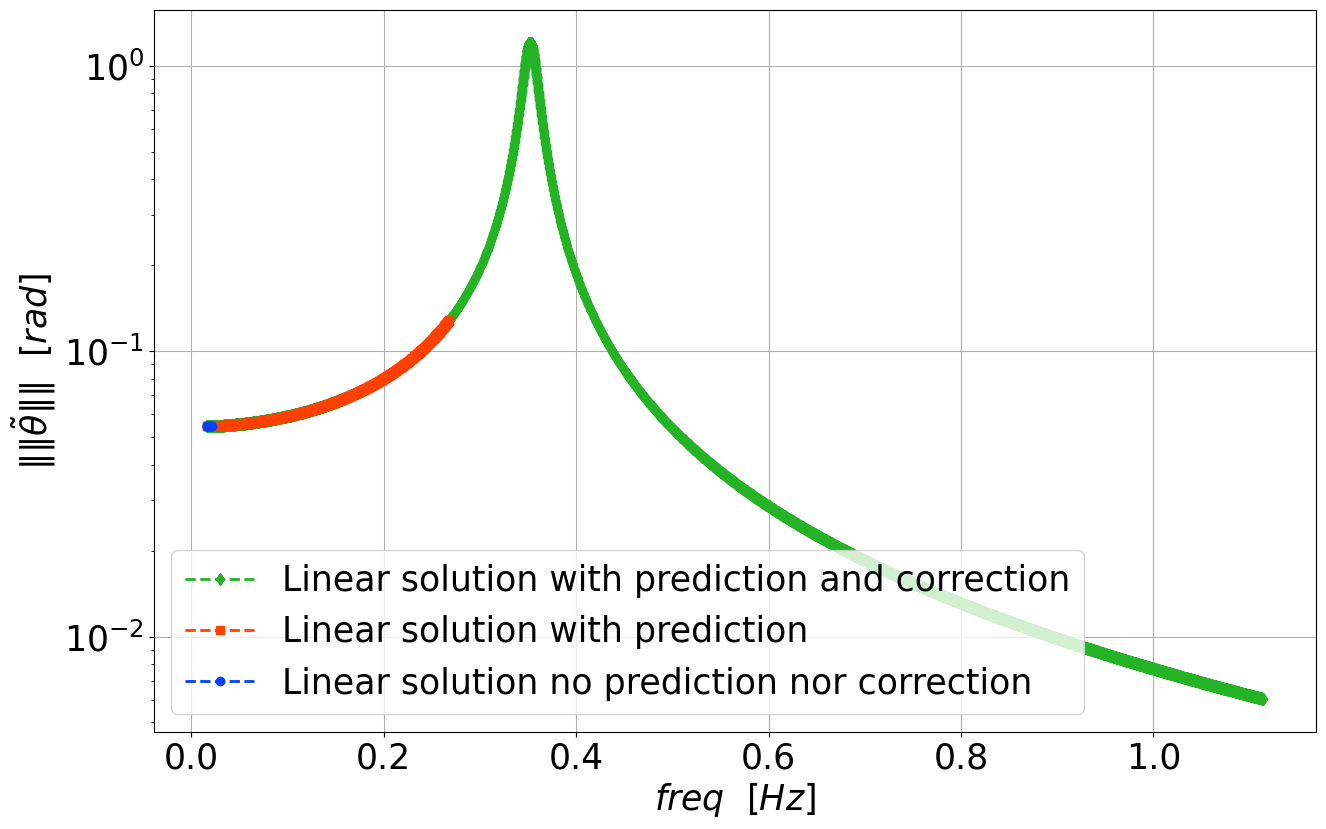

In [10]:
# -------------------- Draw of the frf -------------------- #
SA_predcor, om_predcor, ampH_predcor = get_frf(PredCor) # from the Maestro object, we extract some FRF by run the 
# get_frf function defined at the top of the notebook

fig,ax = plt.subplots(figsize=ratio_fig)
ax.plot(om_predcor/(2*np.pi),ampH_predcor,**style_plots_ref["frf_lin_predcor"])
ax.plot(om_pred/(2*np.pi),ampH_pred,**style_plots_ref["frf_lin_pred"])
ax.plot(om_lin_nothing/(2*np.pi),ampH_lin_nothing,**style_plots_ref["frf_lin_nothing"])
ax.set_xlabel("$freq~~[Hz]$")
ax.set_ylabel("$\|\| \\tilde{\\theta} \|\|~~[rad]$")
ax.legend()
ax.grid()
ax.set_yscale("log")


## Turning points and the importance of bifurcations
Another benefit of the prediction/correction mechanism is the handling of **turning points**. The **turning points** are specific points of the response curves and are **bifurcations** of the response curve. Their main effect is that the response curve to be followed needs to change sign in $\omega$ and those phenomena only appear when studying nonlinear systems.

In the next block we introduce the cubic nonlinearity studied in the Tuto_002 that represents an approximation of the nonlinearity present in the pendulum equation. The analysis will be run going forward the axis of angular frequency and a second analysis is create on the same exact problem but backward. 
- Complete the value needed for the cubic connector or use the function present in the correction of the previous tutorial `cubic_problem_corr`

In [11]:
from Tuto_002_AFTscheme_correctionfunctions import cubic_problem_corr

### USER MODIFICATIONS ATTENDED ###
# Now we add a new connector corresponding to the cubic part using a "CubicSpring" type
def cubic_problem(g:float,R:float) -> float:
    return 0
### END USER MODIFICATION ###


# -------------------- Cubic problem -------------------- #
INP_cub = copy.deepcopy(INP)
INP_cub["analysis"]["FRF"]["predictor"] = "tangent"
INP_cub["analysis"]["FRF_backward"] = copy.deepcopy(INP_cub["analysis"]["FRF"])
INP_cub["analysis"]["FRF_backward"]["sign_ds"] = -1

# The linearSpring connector is added like previously
INP_cub["connectors"]["linGravity"] = {
    "type":"LinearSpring",
    "connect" : {"sub1":[0]},
    "dirs":[0],
    "k" : g/R
        }
# Now we add a new connector corresponding to the cubic part using a "CubicSpring" type
def cubic_problem(g,R):
    return 0 # to be modified
INP_cub["connectors"]["cubicGravity"] = {
    "type":"CubicSpring",
    "connect" : {"sub1":[0]},
    "dirs":[0],
    "k" : cubic_problem_corr(g,R) # introduce the value of the coefficient to allocate to the cubic spring
        }
Cub = pyHarm.Maestro(INP_cub)
Cub.operate("null")

solution converged at om=0.1
solution converged at om=0.1029999906857695
solution converged at om=0.10599998091275058
solution converged at om=0.10899997066690727
solution converged at om=0.11199995993416155
solution converged at om=0.11499994870039205
solution converged at om=0.1179999369514328
solution converged at om=0.1209999246730719
solution converged at om=0.12399991185105029
solution converged at om=0.12699989847106039
solution converged at om=0.12999988451874478
solution converged at om=0.13299986997969496
solution converged at om=0.13599985483944993
solution converged at om=0.13899983908349495
solution converged at om=0.14199982269726014
solution converged at om=0.14499980566611914
solution converged at om=0.14799978797538782
solution converged at om=0.1509997696103228
solution converged at om=0.15399975055612017
solution converged at om=0.15699973079791413
solution converged at om=0.15999971032077548
solution converged at om=0.16299968910971036
solution converged at om=0.165

In [16]:
SA_cub, om_cub, ampH_cub = get_frf(Cub)
SA_cubB, om_cubB, ampH_cubB = get_frf(Cub,analysis="FRF_backward")

fig,ax = plt.subplots(figsize=ratio_fig)
ax.plot(om_predcor/(2*np.pi),ampH_predcor,**style_plots_ref["frf_lin"])
ax.plot(om_cub/(2*np.pi),ampH_cub,**style_plots_ref["frf_nl_cubic"])
ax.plot(om_cubB/(2*np.pi),ampH_cubB,**style_plots_ref["frf_nl_cubicB"])
ax.set_xlabel("$freq~~[Hz]$")
ax.set_ylabel("$\|\| \\tilde{\\theta} \|\|~~[rad]$")
ax.legend()
ax.grid()
ax.set_yscale("log")


Using only a predictor and keeping the corrector to impose a fix $\omega$ the solver is not able to converge on the solution branch. The points where the solver fail are turning points and can be detected using test functions when more complex corrector equations are used. Once the **turning point** is detected, the code knows that the direction of prediction needs to change sign and does it accordingly. 

In [13]:
INP_cub_bifurc = copy.deepcopy(INP)
INP_cub_bifurc["analysis"]["FRF"]["predictor"] = "tangent"
INP_cub_bifurc["analysis"]["FRF"]["corrector"] = "pseudo_arc_length"

# The linearSpring connector is added like previously
INP_cub_bifurc["connectors"]["linGravity"] = {
    "type":"LinearSpring",
    "connect" : {"sub1":[0]},
    "dirs":[0],
    "k" : g/R
        }
# Now we add a new connector corresponding to the cubic part using a "CubicSpring" type
def cubic_problem(g,R):
    return 0 # to be modified
INP_cub_bifurc["connectors"]["cubicGravity"] = {
    "type":"CubicSpring",
    "connect" : {"sub1":[0]},
    "dirs":[0],
    "k" : cubic_problem_corr(g,R) # introduce the value of the coefficient to allocate to the cubic spring
        }
Cub_bifurc = pyHarm.Maestro(INP_cub_bifurc)
Cub_bifurc.operate("null")

solution converged at om=0.1
solution converged at om=0.10299999045980822
solution converged at om=0.10599998045381692
solution converged at om=0.10899996996796936
solution converged at om=0.11199995898816603
solution converged at om=0.11499994750026349
solution converged at om=0.11799993549007302
solution converged at om=0.12099992294335937
solution converged at om=0.12399990984583943
solution converged at om=0.12699989618318092
solution converged at om=0.1299998819410011
solution converged at om=0.13299986710486544
solution converged at om=0.1359998516602863
solution converged at om=0.1389998355927216
solution converged at om=0.1419998188875735
solution converged at om=0.14499980153018688
solution converged at om=0.14799978350584828
solution converged at om=0.15099976479978428
solution converged at om=0.15399974539716024
solution converged at om=0.1569997252830789
solution converged at om=0.15999970444257897
solution converged at om=0.16299968286063374
solution converged at om=0.1659

Before going to the figure, look at the printing log emitted during the analysis. Once fold bifurcation is detected the code changes the direction of prediction in order to follow the curve when the sign of $\delta \omega$ needs to change

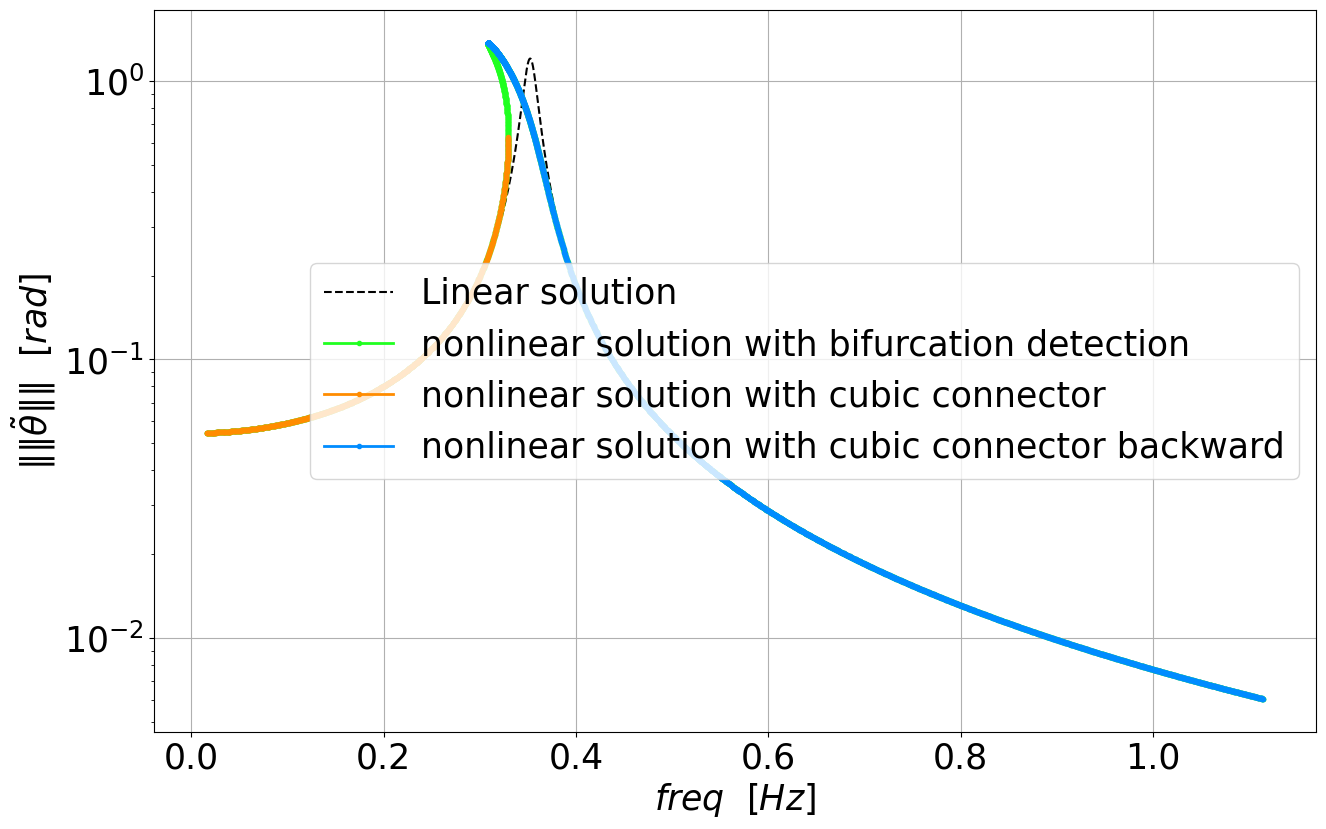

In [14]:
SA_cub_bifurc, om_cub_bifurc, ampH_cub_bifurc = get_frf(Cub_bifurc)

fig,ax = plt.subplots(figsize=ratio_fig)
ax.plot(om_predcor/(2*np.pi),ampH_predcor,**style_plots_ref["frf_lin"])
ax.plot(om_cub_bifurc/(2*np.pi),ampH_cub_bifurc,**style_plots_ref["frf_nl_bifurc"])
ax.plot(om_cub/(2*np.pi),ampH_cub,**style_plots_ref["frf_nl_cubic"])
ax.plot(om_cubB/(2*np.pi),ampH_cubB,**style_plots_ref["frf_nl_cubicB"])
ax.set_xlabel("$freq~~[Hz]$")
ax.set_ylabel("$\|\| \\tilde{\\theta} \|\|~~[rad]$")
ax.legend()
ax.grid()
ax.set_yscale("log")


# Conclusion 

The prediction/correction method serves more than a single purpose in the HBM framework. On one side it allows to give the nonlinear solver a better initial guess helping on obtaining the convergence and on the speed of the convergence. On the second hand the correction term allows for more flexibility to the solver that is able to look for a solution in a bigger space by acting onto the angular frequency itself ensuring a better convergence rate as well. But this augmented system of equations also allows to detect and treat specific points with more accuracy. The turning points can become quite challenging or even not possible to solve if they are not detected and treated the right way. 

The next tutorial will be addressing friction mechanisms.

